In [1]:
import subprocess
import os
import pandas as pd
#import netCDF4
import numpy as np
import glob
import time
import matplotlib.pyplot as plt
import copy
import xarray as xr
from datetime import datetime, timedelta 
import dask
from scipy.interpolate import griddata
#from ocean_c_lab_tools import *
#from celluloid import Camera 
#import PyCO2SYS as csys
import seawater as sw
from roms_regrid import *

/tmp/ipykernel_391752/3945946454.py:17: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


In [2]:
xls = pd.ExcelFile('/global/cfs/cdirs/m4632/uheede/Hafro_obsdata/20241210_biogeochemistry_format.xlsx')
combo = pd.read_excel(xls, 'Sheet1',decimal='.')


obs=xr.Dataset.from_dataframe(combo)
obs=obs.set_index(index=['HV','depth_bin','date'])
obs=obs.drop_duplicates('index')
obs=obs.unstack('index')
obs=obs.rename(name_dict={'Latitude(°N)':'lat','Longitude(°E)':'lon'})



In [3]:
obs

<xarray.Dataset> Size: 242kB
Dimensions:       (HV: 10, depth_bin: 8, date: 14)
Coordinates:
  * HV            (HV) int64 80B 1 3 4 5 6 7 8 9 10 12
  * depth_bin     (depth_bin) int64 64B 0 10 20 30 50 60 70 80
  * date          (date) datetime64[ns] 112B 2024-04-04 ... 2024-11-21
Data variables: (12/27)
    cruise        (HV, depth_bin, date) object 9kB '46BS0524' '46SF0224' ... nan
    year          (HV, depth_bin, date) float64 9kB 2.024e+03 2.024e+03 ... nan
    month         (HV, depth_bin, date) float64 9kB 4.0 4.0 4.0 ... nan nan nan
    day           (HV, depth_bin, date) float64 9kB 4.0 16.0 26.0 ... nan nan
    hour          (HV, depth_bin, date) float64 9kB 8.0 12.0 10.0 ... nan nan
    minute        (HV, depth_bin, date) float64 9kB 56.0 24.0 38.0 ... nan nan
    ...            ...
    SiO2          (HV, depth_bin, date) float64 9kB 5.26 2.93 3.93 ... nan nan
    flask3        (HV, depth_bin, date) object 9kB 301 1055 1073 ... nan nan nan
    NH4           (HV, depth_bin, date) float64 9kB 0.2681 0.4046 ... nan nan
    flask4        (HV, depth_bin, date) float64 9kB 3.0 28.0 46.0 ... nan nan
    TpH           (HV, depth_bin, date) float64 9kB 25.05 25.05 ... nan nan
    pH @TpH       (HV, depth_bin, date) float64 9kB 7.8 7.829 7.847 ... nan nan

In [4]:
density=sw.dens0(obs['S'],obs['T'])
obs['Alk']=obs['TA'] * (1 / 1000) * density
obs['DIC']=obs['DIC'] * (1 / 1000) * density

In [5]:
TA0=274
Sref=34
DIC0=315
nTA=((obs['Alk']-TA0)/obs['S'])*Sref+TA0

nDIC=((obs['DIC']-DIC0)/obs['S'])*Sref+DIC0

In [6]:
model=xr.open_mfdataset('/pscratch/sd/u/uheede/Iceland3_MARBL_new/z_Iceland3_MARBL_bgc_avg.2023??????????.nc', combine='nested', concat_dim=["time"])
model1=xr.open_mfdataset('/pscratch/sd/u/uheede/Iceland3_MARBL_new/z_Iceland3_MARBL_rnd.2023??????????.nc', combine='nested', concat_dim=["time"])
s=model1['s'].thin({'depth': 5})

bgc=model[['ALK','DIC','PO4','NO3','SiO3','NH4','O2']]
grid=xr.open_mfdataset('/global/cfs/cdirs/m4632/uheede/work/Iceland3_phys/INPUT_RIV/Iceland3_grd.nc')
bgc=bgc.thin({'depth': 5})

bgc=roms_regrid(grid,bgc.isel(time=slice(0,94)))
s=roms_regrid(grid,s.isel(time=slice(0,94)))

In [7]:
bgc

<xarray.Dataset> Size: 8GB
Dimensions:  (time: 48, depth: 11, lat: 722, lon: 722)
Coordinates:
  * depth    (depth) float32 44B -0.0 -2.5 -5.0 -10.0 ... -40.0 -70.0 -140.0
  * lon      (lon) float64 6kB 337.2 337.2 337.2 337.2 ... 338.7 338.7 338.7
  * lat      (lat) float64 6kB 63.92 63.92 63.93 63.93 ... 64.57 64.57 64.57
Dimensions without coordinates: time
Data variables:
    ALK      (time, depth, lat, lon) float32 1GB dask.array<chunksize=(7, 11, 722, 722), meta=np.ndarray>
    DIC      (time, depth, lat, lon) float32 1GB dask.array<chunksize=(7, 11, 722, 722), meta=np.ndarray>
    PO4      (time, depth, lat, lon) float32 1GB dask.array<chunksize=(7, 11, 722, 722), meta=np.ndarray>
    NO3      (time, depth, lat, lon) float32 1GB dask.array<chunksize=(7, 11, 722, 722), meta=np.ndarray>
    SiO3     (time, depth, lat, lon) float32 1GB dask.array<chunksize=(7, 11, 722, 722), meta=np.ndarray>
    NH4      (time, depth, lat, lon) float32 1GB dask.array<chunksize=(7, 11, 722, 722), meta=np.ndarray>
    O2       (time, depth, lat, lon) float32 1GB dask.array<chunksize=(7, 11, 722, 722), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [8]:
nTA_model=((bgc['ALK']-TA0)/s)*Sref+TA0

nDIC_model=((bgc['DIC']-DIC0)/s)*Sref+DIC0

In [9]:
bgc['nTA']=nTA_model
bgc['nDIC']=nDIC_model

In [10]:
# define location which calculations the average location of each station
def get_location(obs, hv_values):
    locations = []
    for hv in hv_values:
        lat = (obs['lat'].sel(HV=hv).isel(depth_bin=0).mean('date').squeeze()).values+0
        lon = obs['lon'].sel(HV=hv).isel(depth_bin=0).mean('date').squeeze().values + 360
        locations.append([lat, lon])
    return locations

# List of HV values
hv_values = 1,3,5,7,9,10,12

# Get the locations
locations = get_location(obs, hv_values)

In [11]:
# Assuming locations is a list of lat/lon pairs
bgc_values = []

# Loop over the first 10 locations and store each selection in t_values
for i in range(7):
    lat, lon = locations[i]
    
    # Select the 't' values at the nearest lat/lon
    bgc_selected = bgc.sel(lat=lat, method='nearest').sel(lon=lon, method='nearest')
    
    # Store the result in the list
    bgc_values.append(bgc_selected)

# Combine the selections into an xarray Dataset or DataArray
bgc_values_combined = xr.concat(bgc_values, dim='location')

# Assign a location coordinate for clarity (optional)
bgc_values_combined = bgc_values_combined.assign_coords(location=('location', [1,3,5,7,9,10,12]))
bgc_values_combined['depth']=bgc_values_combined.depth*(-1)


In [12]:

#x=xr.open_mfdataset('/pscratch/sd/u/uheede/from_expanse/Iceland3/*', combine='nested', concat_dim=["time"])

# open grid
grid=xr.open_mfdataset('/global/cfs/cdirs/m4632/uheede/roms_setups/Iceland3_MARBL/1.Make_grid/Iceland3_grd.nc')



# regridding
h=roms_regrid(grid,grid['h'])

mask=roms_regrid(grid,grid['mask_rho'])

;

''

In [13]:
reference_date = np.datetime64('2000-01-01T00:00:00')
datetime_array = reference_date + (model['ocean_time']).astype('timedelta64[s]')
model['ocean_time']=datetime_array

In [14]:
bgc_values_combined=bgc_values_combined.assign_coords(time=model['ocean_time'])

/tmp/ipykernel_391752/659707699.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  bgc_values_combined=bgc_values_combined.assign_coords(time=model['ocean_time'])
/tmp/ipykernel_391752/659707699.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silence

In [15]:
bgc_sub=bgc_values_combined.sel(time=(['2023-04-17T00:00:00.000000000', '2023-04-18T00:00:00.000000000',
       '2023-04-26T00:00:00.000000000', '2023-05-13T00:00:00.000000000',
       '2023-05-28T00:00:00.000000000', '2023-06-11T00:00:00.000000000',
       '2023-06-26T00:00:00.000000000','2023-07-09T00:00:00.000000000','2023-07-25T00:00:00.000000000']), method='nearest')

/tmp/ipykernel_391752/1447354073.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  bgc_sub=bgc_values_combined.sel(time=(['2023-04-17T00:00:00.000000000', '2023-04-18T00:00:00.000000000',


In [16]:
bgc_sub.load()

/global/homes/u/uheede/.conda/envs/xesmf_env/lib/python3.12/site-packages/dask/_task_spec.py:651: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/global/homes/u/uheede/.conda/envs/xesmf_env/lib/python3.12/site-packages/dask/_task_spec.py:651: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/global/homes/u/uheede/.conda/envs/xesmf_env/lib/python3.12/site-packages/dask/_task_spec.py:651: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/global/homes/u/uheede/.conda/envs/xesmf_env/lib/python3.12/site-packages/dask/_task_spec.py:651: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/global/homes/u/uheede/.conda/envs/xesmf_env/lib/python3.12/site-packages/dask/_task_spec.py:651: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/global/homes/u/uheede/.conda/envs/xesmf_env/lib/python3.12/site-packages/dask/_

<xarray.Dataset> Size: 25kB
Dimensions:   (location: 7, time: 9, depth: 11)
Coordinates:
  * depth     (depth) float32 44B 0.0 2.5 5.0 10.0 15.0 ... 30.0 40.0 70.0 140.0
    lon       (location) float64 56B 338.0 338.1 338.2 338.3 338.4 338.5 338.5
    lat       (location) float64 56B 64.26 64.3 64.34 64.36 64.39 64.38 64.36
  * location  (location) int64 56B 1 3 5 7 9 10 12
  * time      (time) datetime64[ns] 72B 2023-04-20T23:59:20 ... 2023-06-08
Data variables:
    ALK       (location, time, depth) float32 3kB 2.288e+03 2.288e+03 ... nan
    DIC       (location, time, depth) float32 3kB 2.101e+03 2.101e+03 ... nan
    PO4       (location, time, depth) float32 3kB 0.4982 0.5009 ... nan nan
    NO3       (location, time, depth) float32 3kB 18.18 18.14 18.1 ... nan nan
    SiO3      (location, time, depth) float32 3kB 6.596 6.596 6.596 ... nan nan
    NH4       (location, time, depth) float32 3kB 6.573 6.47 6.414 ... nan nan
    O2        (location, time, depth) float32 3kB 328.8 328.9 329.0 ... nan nan
    nTA       (location, time, depth) float32 3kB 2.26e+03 2.26e+03 ... nan nan
    nDIC      (location, time, depth) float32 3kB 2.076e+03 2.076e+03 ... nan
Attributes:
    regrid_method:  bilinear

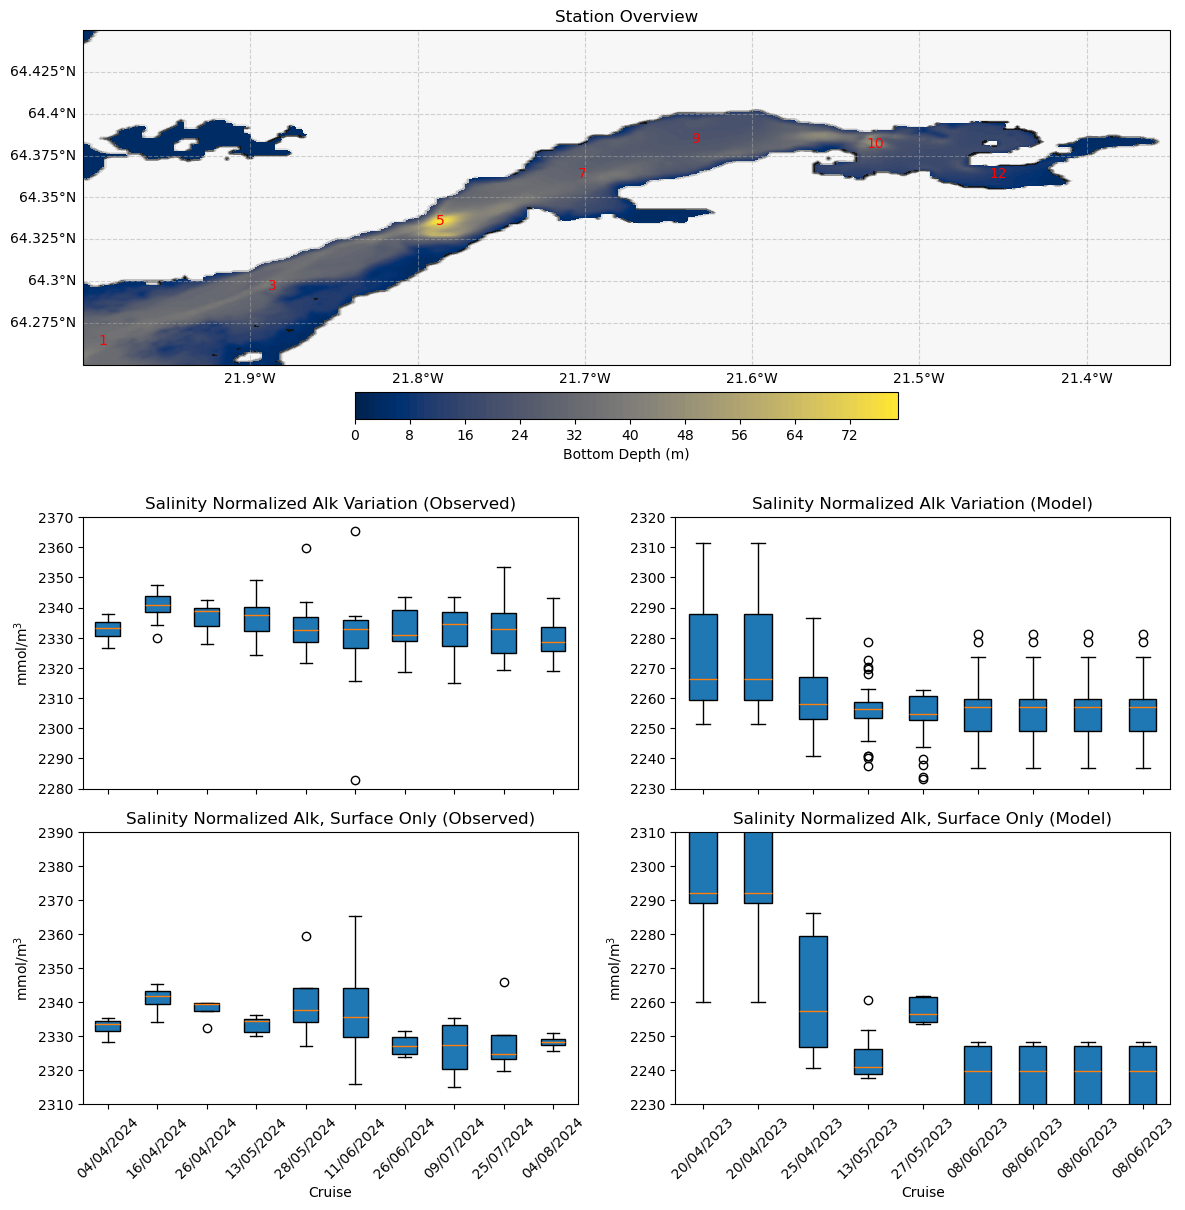

In [17]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define depth levels
levels = np.arange(0, 80)

# Create figure and subplots (3 rows: 1 for the map, 2 for boxplots)
fig = plt.figure(figsize=(12, 13))  # Wider figure for side-by-side plots
gs = fig.add_gridspec(3, 2, height_ratios=[2, 1, 1], width_ratios=[1, 1])  

# --- Shared Map (Top Row, Spanning Both Columns) ---
ax_map = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree())

# Plot bathymetry
cf1 = ax_map.contourf(h.lon, h.lat, h, levels, transform=ccrs.PlateCarree(), cmap='cividis')
ax_map.contourf(h.lon, h.lat, mask.where(mask != 1), cmap='Greys', transform=ccrs.PlateCarree())

# Add station labels
for i, e in enumerate(locations):
    ax_map.text(e[1], e[0], hv_values[i], color='red', size=10, ha='center', va='center', transform=ccrs.PlateCarree())

# Gridlines
gls = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, color='darkgray', alpha=0.5, linestyle='--')
gls.top_labels = False
gls.right_labels = False

# Colorbar
cb1 = plt.colorbar(cf1, shrink=0.5, ax=ax_map, orientation='horizontal', pad=0.05)
cb1.set_label('Bottom Depth (m)', fontsize=10)

ax_map.set_extent([-22, -21.35, 64.25, 64.45], ccrs.PlateCarree())
ax_map.set_title('Station Overview')

# --- Function for Extracting Data ---
def extract_cruise_data(var, depth=None, num_cruises=10):
    """Extracts non-NaN values for a given variable across cruises."""
    cruises = []
    for i in range(num_cruises):
        data = np.hstack(var.isel(date=i) if depth is None else var.isel(date=i, depth_bin=depth))
        cruises.append(data[~np.isnan(data)])
    return cruises

def extract_model_data(var, depth=None, num_cruises=9):
    """Extracts non-NaN values from the model across time steps."""
    cruises = []
    for i in range(num_cruises):
        data = np.hstack(var.isel(time=i) if depth is None else var.isel(time=i, depth=depth))
        cruises.append(data[~np.isnan(data)])
    return cruises

# --- Boxplots for Observations (Left) and Model (Right) ---
ax_obs = fig.add_subplot(gs[1, 0])  # Observations
ax_model = fig.add_subplot(gs[1, 1])  # Model

ax_obs.boxplot(extract_cruise_data(nTA), patch_artist=True)
ax_obs.set_title('Salinity Normalized Alk Variation (Observed)')
ax_obs.set_ylabel('mmol/m$^3$')
ax_obs.set_xticklabels([])
ax_obs.set_ylim(2280,2370)

ax_model.boxplot(extract_model_data(bgc_sub['nTA']), patch_artist=True)
ax_model.set_title('Salinity Normalized Alk Variation (Model)')
ax_model.set_xticklabels([])
ax_model.set_ylim(2230,2320)

# --- Surface-Only Boxplots for Observations (Left) and Model (Right) ---
ax_obs_surface = fig.add_subplot(gs[2, 0])  # Observations (Surface)
ax_model_surface = fig.add_subplot(gs[2, 1])  # Model (Surface)

ax_obs_surface.boxplot(extract_cruise_data(nTA, depth=0), patch_artist=True)
ax_obs_surface.set_title('Salinity Normalized Alk, Surface Only (Observed)')
ax_obs_surface.set_xlabel('Cruise')
ax_obs_surface.set_ylabel('mmol/m$^3$')
ax_obs_surface.set_xticklabels(pd.to_datetime(obs['date'].isel(date=slice(0,10))).strftime('%d/%m/%Y'), rotation=45)
ax_obs_surface.set_ylim(2310,2390)

ax_model_surface.boxplot(extract_model_data(bgc_sub['nTA'], depth=0), patch_artist=True)
ax_model_surface.set_title('Salinity Normalized Alk, Surface Only (Model)')
ax_model_surface.set_xlabel('Cruise')
ax_model_surface.set_ylabel('mmol/m$^3$')
ax_model_surface.set_xticklabels(pd.to_datetime(bgc_sub['time']).strftime('%d/%m/%Y'), rotation=45)
ax_model_surface.set_ylim(2230,2310)

plt.tight_layout()
plt.show()


/tmp/ipykernel_391752/3186183734.py:62: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ax_model_surface.set_xticklabels(pd.to_datetime(bgc_sub['time'].isel(time=slice(0,10))).strftime('%d/%m/%Y'), rotation=45)


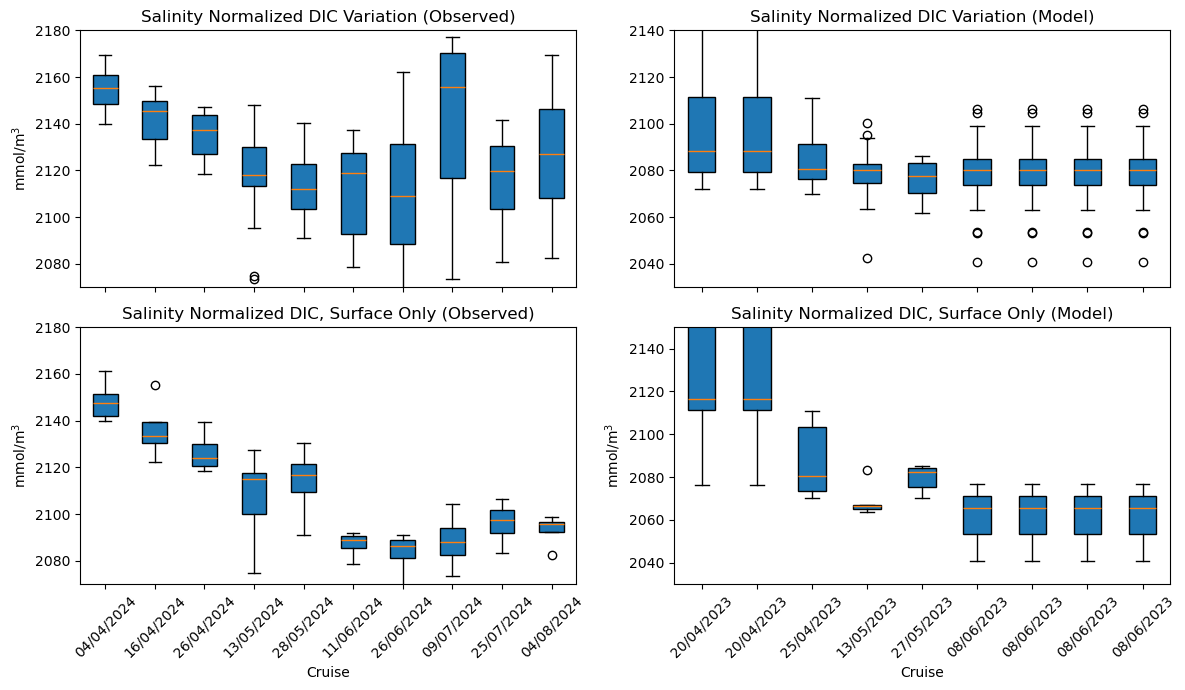

In [18]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define depth levels
levels = np.arange(0, 80)

# Create figure and subplots (3 rows: 1 for the map, 2 for boxplots)
fig = plt.figure(figsize=(12, 7))  # Wider figure for side-by-side plots
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])  



# --- Function for Extracting Data ---
def extract_cruise_data(var, depth=None, num_cruises=10):
    """Extracts non-NaN values for a given variable across cruises."""
    cruises = []
    for i in range(num_cruises):
        data = np.hstack(var.isel(date=i) if depth is None else var.isel(date=i, depth_bin=depth))
        cruises.append(data[~np.isnan(data)])
    return cruises

def extract_model_data(var, depth=None, num_cruises=9):
    """Extracts non-NaN values from the model across time steps."""
    cruises = []
    for i in range(num_cruises):
        data = np.hstack(var.isel(time=i) if depth is None else var.isel(time=i, depth=depth))
        cruises.append(data[~np.isnan(data)])
    return cruises

# --- Boxplots for Observations (Left) and Model (Right) ---
ax_obs = fig.add_subplot(gs[0, 0])  # Observations
ax_model = fig.add_subplot(gs[0, 1])  # Model

ax_obs.boxplot(extract_cruise_data(nDIC), patch_artist=True)
ax_obs.set_title('Salinity Normalized DIC Variation (Observed)')
ax_obs.set_ylabel('mmol/m$^3$')
ax_obs.set_xticklabels([])
ax_obs.set_ylim(2070,2180)

ax_model.boxplot(extract_model_data(bgc_sub['nDIC']), patch_artist=True)
ax_model.set_title('Salinity Normalized DIC Variation (Model)')
ax_model.set_xticklabels([])
ax_model.set_ylim(2030,2140)

# --- Surface-Only Boxplots for Observations (Left) and Model (Right) ---
ax_obs_surface = fig.add_subplot(gs[1, 0])  # Observations (Surface)
ax_model_surface = fig.add_subplot(gs[1, 1])  # Model (Surface)

ax_obs_surface.boxplot(extract_cruise_data(nDIC, depth=0), patch_artist=True)
ax_obs_surface.set_title('Salinity Normalized DIC, Surface Only (Observed)')
ax_obs_surface.set_xlabel('Cruise')
ax_obs_surface.set_ylabel('mmol/m$^3$')
ax_obs_surface.set_xticklabels(pd.to_datetime(obs['date'].isel(date=slice(0,10))).strftime('%d/%m/%Y'), rotation=45)
ax_obs_surface.set_ylim(2070,2180)

ax_model_surface.boxplot(extract_model_data(bgc_sub['nDIC'], depth=0), patch_artist=True)
ax_model_surface.set_title('Salinity Normalized DIC, Surface Only (Model)')
ax_model_surface.set_xlabel('Cruise')
ax_model_surface.set_ylabel('mmol/m$^3$')
ax_model_surface.set_xticklabels(pd.to_datetime(bgc_sub['time'].isel(time=slice(0,10))).strftime('%d/%m/%Y'), rotation=45)
ax_model_surface.set_ylim()
ax_model_surface.set_ylim(2030,2150)

plt.tight_layout()
plt.show()


Text(0, 0.5, 'depth (m)')

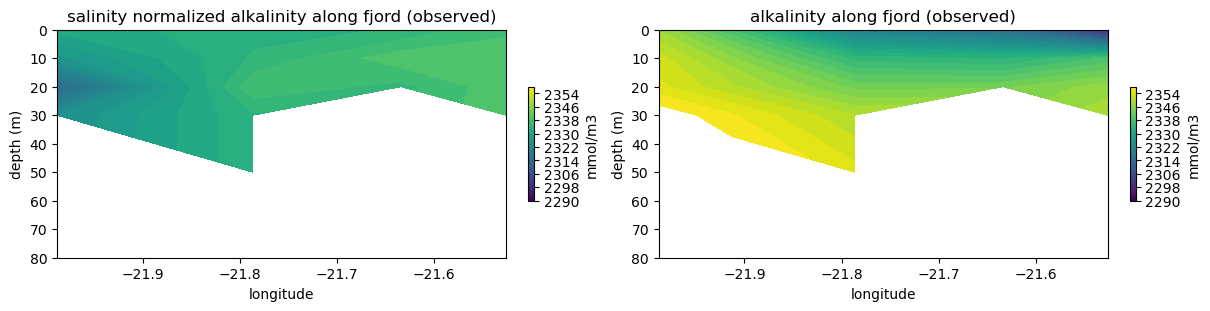

In [19]:
loc = obs['lon'].sel(HV=[1,5,9,10]).isel(depth_bin=0).mean('date').values
depth=obs['depth_bin'].values
levels=np.arange(2290,2360,2)

bins = np.arange(0, 90, 10) 
#depth_bins = xr.DataArray(pd.cut(depth, bins, labels=bins[:-1]), dims="depth", name="binned_depth")

data_alk1=nTA.sel(HV=[1,5,9,10]).isel(date=slice(0,9)).mean('date')
data_alk2=obs['Alk'].sel(HV=[1,5,9,10]).isel(date=slice(0,9)).mean('date')

fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 3), constrained_layout=True)
ax = axarr.flatten()

#c0=ax[0].contourf(loc, data_alk.depth, data_alk.transpose())
c0=ax[0].contourf(loc,data_alk1.depth_bin,data_alk1.transpose(),levels)
plt.colorbar(c0,ax=ax[0], orientation='vertical', label='mmol/m3',shrink=0.5)
ax[0].invert_yaxis()
ax[0].set_title('salinity normalized alkalinity along fjord (observed)')
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('depth (m)')

c0=ax[1].contourf(loc,data_alk2.depth_bin,data_alk2.transpose(),levels)
plt.colorbar(c0,ax=ax[1], orientation='vertical', label='mmol/m3',shrink=0.5)
ax[1].invert_yaxis()
ax[1].set_title('alkalinity along fjord (observed)')
ax[1].set_xlabel('longitude')
ax[1].set_ylabel('depth (m)')

/tmp/ipykernel_391752/2901242744.py:8: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  data_alk1=bgc_sub['nTA'].sel(location=[1,5,9,10]).isel(time=slice(2,7)).mean('time')
/tmp/ipykernel_391752/2901242744.py:9: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be 

Text(0, 0.5, 'depth (m)')

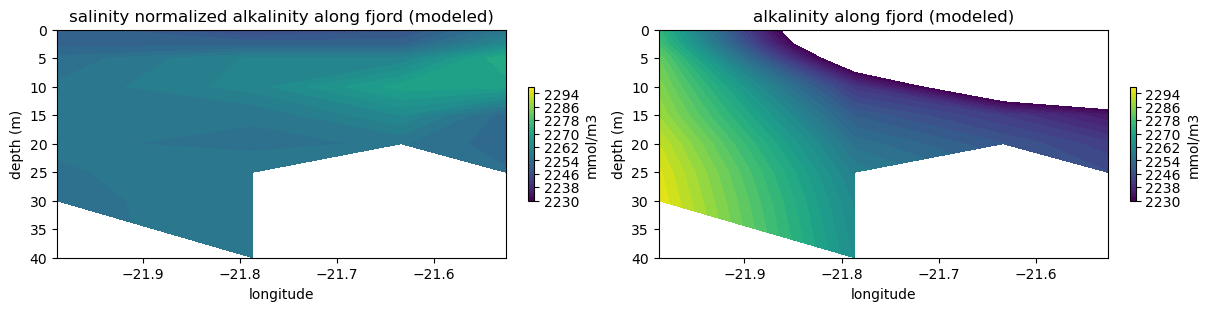

In [20]:
loc = obs['lon'].sel(HV=[1,5,9,10]).isel(depth_bin=0).mean('date').values
depth=obs['depth_bin'].values
levels=np.arange(2230,2300,2)

bins = np.arange(0, 90, 10) 
#depth_bins = xr.DataArray(pd.cut(depth, bins, labels=bins[:-1]), dims="depth", name="binned_depth")

data_alk1=bgc_sub['nTA'].sel(location=[1,5,9,10]).isel(time=slice(2,7)).mean('time')
data_alk2=bgc_sub['ALK'].sel(location=[1,5,9,10]).isel(time=slice(2,7)).mean('time')

fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 3), constrained_layout=True)
ax = axarr.flatten()

#c0=ax[0].contourf(loc, data_alk.depth, data_alk.transpose())
c0=ax[0].contourf(loc,data_alk1.depth,data_alk1.transpose(),levels)
plt.colorbar(c0,ax=ax[0], orientation='vertical', label='mmol/m3',shrink=0.5)
ax[0].set_ylim(0,40)
ax[0].invert_yaxis()
ax[0].set_title('salinity normalized alkalinity along fjord (modeled)')
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('depth (m)')


c0=ax[1].contourf(loc,data_alk2.depth,data_alk2.transpose(),levels)
plt.colorbar(c0,ax=ax[1], orientation='vertical', label='mmol/m3',shrink=0.5)
ax[1].set_ylim(0,40)
ax[1].invert_yaxis()
ax[1].set_title('alkalinity along fjord (modeled)')
ax[1].set_xlabel('longitude')
ax[1].set_ylabel('depth (m)')

/tmp/ipykernel_391752/2478640675.py:16: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  alk_mean_model = bgc_sub['ALK'].sel(location=[1,5,9,10]).isel(time=slice(2,7)).mean(dim=['time', 'location'])
/tmp/ipykernel_391752/2478640675.py:17: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Varia

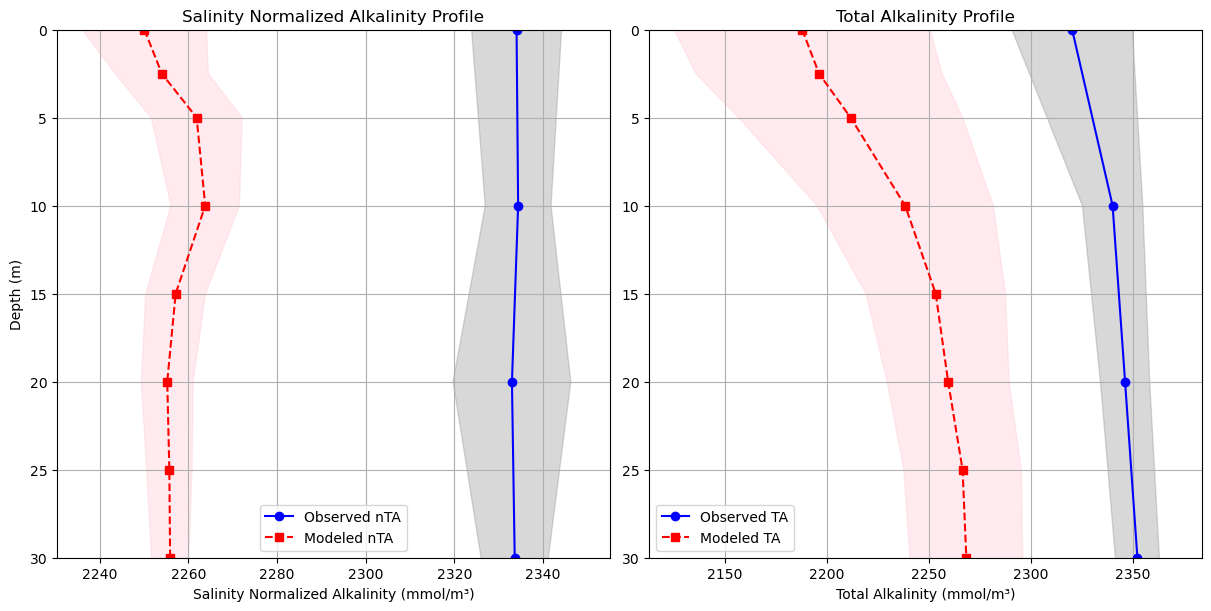

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Compute mean and standard deviation over time for observations
depth_obs = obs['depth_bin'].values
depth_model = bgc_sub['depth'].values

# Observations (Mean and Std Dev)
alk_mean_obs = obs['Alk'].sel(HV=[1,5,9,10]).isel(date=slice(0,9)).mean(dim=['date', 'HV'])
alk_std_obs = obs['Alk'].sel(HV=[1,5,9,10]).isel(date=slice(0,9)).std(dim=['date', 'HV'])

nalk_mean_obs = nTA.sel(HV=[1,5,9,10]).isel(date=slice(0,9)).mean(dim=['date', 'HV'])
nalk_std_obs = nTA.sel(HV=[1,5,9,10]).isel(date=slice(0,9)).std(dim=['date', 'HV'])

# Model (Mean and Std Dev)
alk_mean_model = bgc_sub['ALK'].sel(location=[1,5,9,10]).isel(time=slice(2,7)).mean(dim=['time', 'location'])
alk_std_model = bgc_sub['ALK'].sel(location=[1,5,9,10]).isel(time=slice(2,7)).std(dim=['time', 'location'])

nalk_mean_model = bgc_sub['nTA'].sel(location=[1,5,9,10]).isel(time=slice(2,7)).mean(dim=['time', 'location'])
nalk_std_model = bgc_sub['nTA'].sel(location=[1,5,9,10]).isel(time=slice(2,7)).std(dim=['time', 'location'])

# Create figure with 2 columns (nTA on left, TA on right)
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), constrained_layout=True)
ax = axarr.flatten()

# --- Plot Salinity Normalized Alkalinity (nTA) ---
ax[0].plot(nalk_mean_obs, depth_obs, marker='o', linestyle='-', color='b', label='Observed nTA')
ax[0].fill_betweenx(depth_obs, nalk_mean_obs - nalk_std_obs, nalk_mean_obs + nalk_std_obs, color='gray', alpha=0.3)

ax[0].plot(nalk_mean_model, depth_model, marker='s', linestyle='--', color='r', label='Modeled nTA')
ax[0].fill_betweenx(depth_model, nalk_mean_model - nalk_std_model, nalk_mean_model + nalk_std_model, color='pink', alpha=0.3)

ax[0].set_ylim(0,30)
ax[0].invert_yaxis()
ax[0].set_xlabel('Salinity Normalized Alkalinity (mmol/m³)')
ax[0].set_ylabel('Depth (m)')
ax[0].set_title('Salinity Normalized Alkalinity Profile')
ax[0].legend()
ax[0].grid()

# --- Plot Total Alkalinity (TA) ---
ax[1].plot(alk_mean_obs, depth_obs, marker='o', linestyle='-', color='b', label='Observed TA')
ax[1].fill_betweenx(depth_obs, alk_mean_obs - alk_std_obs, alk_mean_obs + alk_std_obs, color='gray', alpha=0.3)

ax[1].plot(alk_mean_model, depth_model, marker='s', linestyle='--', color='r', label='Modeled TA')
ax[1].fill_betweenx(depth_model, alk_mean_model - alk_std_model, alk_mean_model + alk_std_model, color='pink', alpha=0.3)
ax[1].set_ylim(0,30)
ax[1].invert_yaxis()
ax[1].set_xlabel('Total Alkalinity (mmol/m³)')
ax[1].set_title('Total Alkalinity Profile')
ax[1].legend()
ax[1].grid()

plt.show()


/tmp/ipykernel_391752/1191234110.py:16: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  alk_mean_model = bgc_sub['DIC'].sel(location=[1,5,9,10]).isel(time=slice(2,7)).mean(dim=['time', 'location'])
/tmp/ipykernel_391752/1191234110.py:17: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Varia

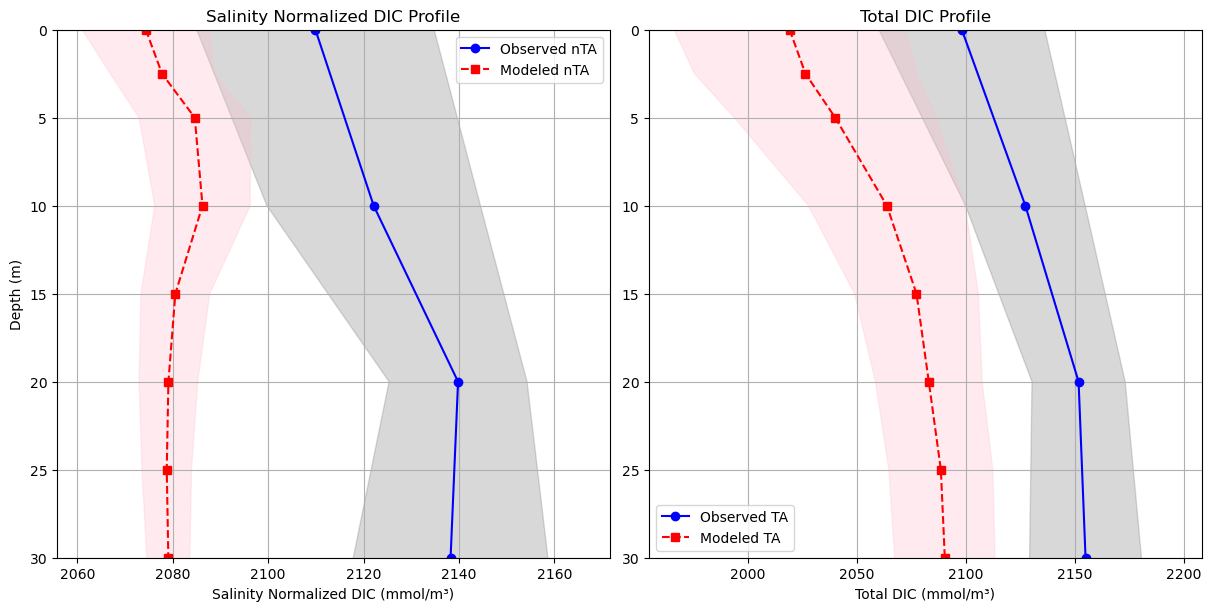

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Compute mean and standard deviation over time for observations
depth_obs = obs['depth_bin'].values
depth_model = bgc_sub['depth'].values

# Observations (Mean and Std Dev)
alk_mean_obs = obs['DIC'].sel(HV=[1,5,9,10]).isel(date=slice(0,9)).mean(dim=['date', 'HV'])
alk_std_obs = obs['DIC'].sel(HV=[1,5,9,10]).isel(date=slice(0,9)).std(dim=['date', 'HV'])

nalk_mean_obs = nDIC.sel(HV=[1,5,9,10]).isel(date=slice(0,9)).mean(dim=['date', 'HV'])
nalk_std_obs = nDIC.sel(HV=[1,5,9,10]).isel(date=slice(0,9)).std(dim=['date', 'HV'])

# Model (Mean and Std Dev)
alk_mean_model = bgc_sub['DIC'].sel(location=[1,5,9,10]).isel(time=slice(2,7)).mean(dim=['time', 'location'])
alk_std_model = bgc_sub['DIC'].sel(location=[1,5,9,10]).isel(time=slice(2,7)).std(dim=['time', 'location'])

nalk_mean_model = bgc_sub['nDIC'].sel(location=[1,5,9,10]).isel(time=slice(2,7)).mean(dim=['time', 'location'])
nalk_std_model = bgc_sub['nDIC'].sel(location=[1,5,9,10]).isel(time=slice(2,7)).std(dim=['time', 'location'])

# Create figure with 2 columns (nTA on left, TA on right)
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), constrained_layout=True)
ax = axarr.flatten()

# --- Plot Salinity Normalized Alkalinity (nTA) ---
ax[0].plot(nalk_mean_obs, depth_obs, marker='o', linestyle='-', color='b', label='Observed nTA')
ax[0].fill_betweenx(depth_obs, nalk_mean_obs - nalk_std_obs, nalk_mean_obs + nalk_std_obs, color='gray', alpha=0.3)

ax[0].plot(nalk_mean_model, depth_model, marker='s', linestyle='--', color='r', label='Modeled nTA')
ax[0].fill_betweenx(depth_model, nalk_mean_model - nalk_std_model, nalk_mean_model + nalk_std_model, color='pink', alpha=0.3)

ax[0].set_ylim(0,30)
ax[0].invert_yaxis()
ax[0].set_xlabel('Salinity Normalized DIC (mmol/m³)')
ax[0].set_ylabel('Depth (m)')
ax[0].set_title('Salinity Normalized DIC Profile')
ax[0].legend()
ax[0].grid()

# --- Plot Total Alkalinity (TA) ---
ax[1].plot(alk_mean_obs, depth_obs, marker='o', linestyle='-', color='b', label='Observed TA')
ax[1].fill_betweenx(depth_obs, alk_mean_obs - alk_std_obs, alk_mean_obs + alk_std_obs, color='gray', alpha=0.3)

ax[1].plot(alk_mean_model, depth_model, marker='s', linestyle='--', color='r', label='Modeled TA')
ax[1].fill_betweenx(depth_model, alk_mean_model - alk_std_model, alk_mean_model + alk_std_model, color='pink', alpha=0.3)
ax[1].set_ylim(0,30)
ax[1].invert_yaxis()
ax[1].set_xlabel('Total DIC (mmol/m³)')
ax[1].set_title('Total DIC Profile')
ax[1].legend()
ax[1].grid()

plt.show()


Text(0, 0.5, 'depth (m)')

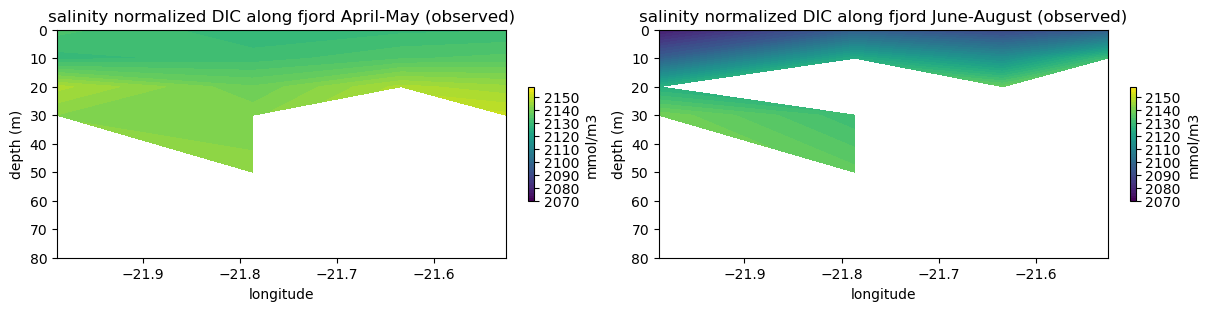

In [23]:
loc = obs['lon'].sel(HV=[1,5,9,10]).isel(depth_bin=0).mean('date').values
depth=obs['depth_bin'].values
levels=np.arange(2070,2160,2)

bins = np.arange(0, 90, 10) 
#depth_bins = xr.DataArray(pd.cut(depth, bins, labels=bins[:-1]), dims="depth", name="binned_depth")

data_alk1=nDIC.sel(HV=[1,5,9,10]).isel(date=slice(0,4)).mean('date')
data_alk2=nDIC.sel(HV=[1,5,9,10]).isel(date=slice(5,9)).mean('date')

fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 3), constrained_layout=True)
ax = axarr.flatten()

#c0=ax[0].contourf(loc, data_alk.depth, data_alk.transpose())
c0=ax[0].contourf(loc,data_alk1.depth_bin,data_alk1.transpose(),levels)
plt.colorbar(c0,ax=ax[0], orientation='vertical', label='mmol/m3',shrink=0.5)
ax[0].invert_yaxis()
ax[0].set_title('salinity normalized DIC along fjord April-May (observed)')
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('depth (m)')

c0=ax[1].contourf(loc,data_alk2.depth_bin,data_alk2.transpose(),levels)
plt.colorbar(c0,ax=ax[1], orientation='vertical', label='mmol/m3',shrink=0.5)
ax[1].invert_yaxis()
ax[1].set_title('salinity normalized DIC along fjord June-August (observed)')
ax[1].set_xlabel('longitude')
ax[1].set_ylabel('depth (m)')

/tmp/ipykernel_391752/3320587714.py:11: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  data_alk1=bgc_sub['nDIC'].sel(location=[1,5,9,10]).isel(time=slice(0,4)).mean('time')
/tmp/ipykernel_391752/3320587714.py:12: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can 

Text(0, 0.5, 'depth (m)')

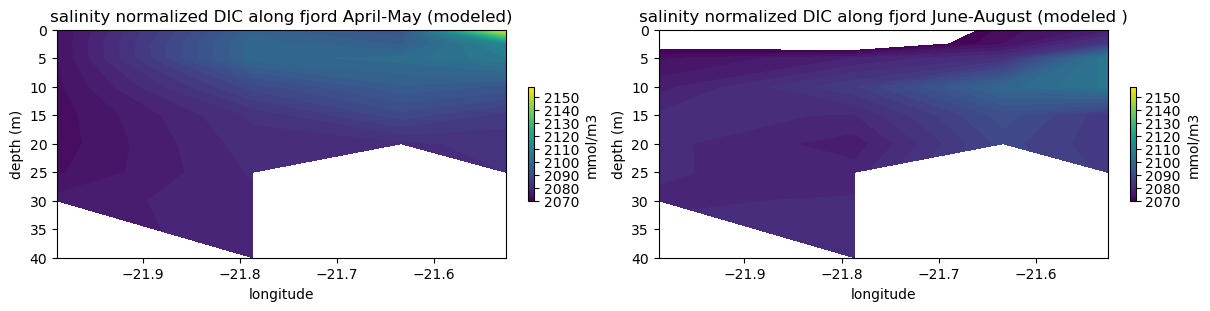

In [24]:
loc = obs['lon'].sel(HV=[1,5,9,10]).isel(depth_bin=0).mean('date').values
depth=obs['depth_bin'].values
levels=np.arange(2070,2160,2)

bins = np.arange(0, 90, 10) 
#depth_bins = xr.DataArray(pd.cut(depth, bins, labels=bins[:-1]), dims="depth", name="binned_depth")

data_alk1=nDIC.sel(HV=[1,5,9,10]).isel(date=slice(0,4)).mean('date')
data_alk2=nDIC.sel(HV=[1,5,9,10]).isel(date=slice(5,9)).mean('date')

data_alk1=bgc_sub['nDIC'].sel(location=[1,5,9,10]).isel(time=slice(0,4)).mean('time')
data_alk2=bgc_sub['nDIC'].sel(location=[1,5,9,10]).isel(time=slice(5,9)).mean('time')


fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 3), constrained_layout=True)
ax = axarr.flatten()

#c0=ax[0].contourf(loc, data_alk.depth, data_alk.transpose())
c0=ax[0].contourf(loc,data_alk1.depth,data_alk1.transpose(),levels)
plt.colorbar(c0,ax=ax[0], orientation='vertical', label='mmol/m3',shrink=0.5)
ax[0].set_ylim(0,40)
ax[0].invert_yaxis()
ax[0].set_title('salinity normalized DIC along fjord April-May (modeled)')
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('depth (m)')

c0=ax[1].contourf(loc,data_alk2.depth,data_alk2.transpose(),levels)
plt.colorbar(c0,ax=ax[1], orientation='vertical', label='mmol/m3',shrink=0.5)
ax[1].set_ylim(0,40)
ax[1].invert_yaxis()
ax[1].set_title('salinity normalized DIC along fjord June-August (modeled )')
ax[1].set_xlabel('longitude')
ax[1].set_ylabel('depth (m)')

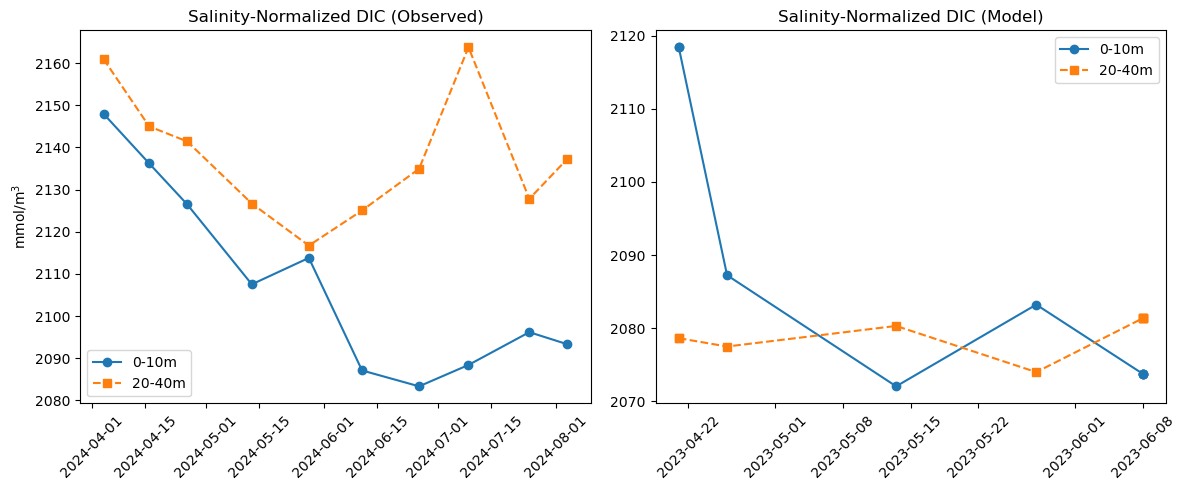

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create figure and subplots (1 row for salinity-normalized DIC, 2 columns for observations vs. model)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharex=False)

# --- Data Extraction Functions ---
def extract_depth_avg(var, depth_range, time_dim='date'):
    """Extracts mean value across a given depth range for each time step."""
    return var.sel(depth_bin=slice(*depth_range)).mean(dim='depth_bin', skipna=True)

def extract_depth_avg_model(var, depth_range, time_dim='time'):
    """Extracts mean value across a given depth range for each time step."""
    return var.sel(depth=slice(*depth_range)).mean(dim='depth', skipna=True)

# Define depth ranges
upper_depth_range = (0, 5)   # Upper level (0-10 m)
lower_depth_range = (20, 40)  # Lower level (20-40 m)

# --- Observations ---
ax_obs = axes[0]
obs_upper = extract_depth_avg(nDIC.mean('HV'), upper_depth_range)
obs_lower = extract_depth_avg(nDIC.mean('HV'), lower_depth_range)

ax_obs.plot(obs['date'], obs_upper, label='0-10m', marker='o', linestyle='-')
ax_obs.plot(obs['date'], obs_lower, label='20-40m', marker='s', linestyle='--')
ax_obs.set_title('Salinity-Normalized DIC (Observed)')
ax_obs.set_ylabel('mmol/m$^3$')
ax_obs.legend()
ax_obs.tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# --- Model ---
ax_model = axes[1]
model_upper = extract_depth_avg_model(bgc_sub['nDIC'].mean('location'), upper_depth_range, time_dim='time')
model_lower = extract_depth_avg_model(bgc_sub['nDIC'].mean('location'), lower_depth_range, time_dim='time')

ax_model.plot(bgc_sub['time'], model_upper, label='0-10m', marker='o', linestyle='-')
ax_model.plot(bgc_sub['time'], model_lower, label='20-40m', marker='s', linestyle='--')
ax_model.set_title('Salinity-Normalized DIC (Model)')
ax_model.legend()
ax_model.tick_params(axis='x', rotation=45)  # Rotate x-axis labels

plt.tight_layout()
plt.show()


/tmp/ipykernel_391752/3374535268.py:79: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ax4_model.set_xticklabels(pd.to_datetime(bgc_sub['time'].isel(time=slice(0,7))).strftime('%d/%m/%Y'), rotation=45)


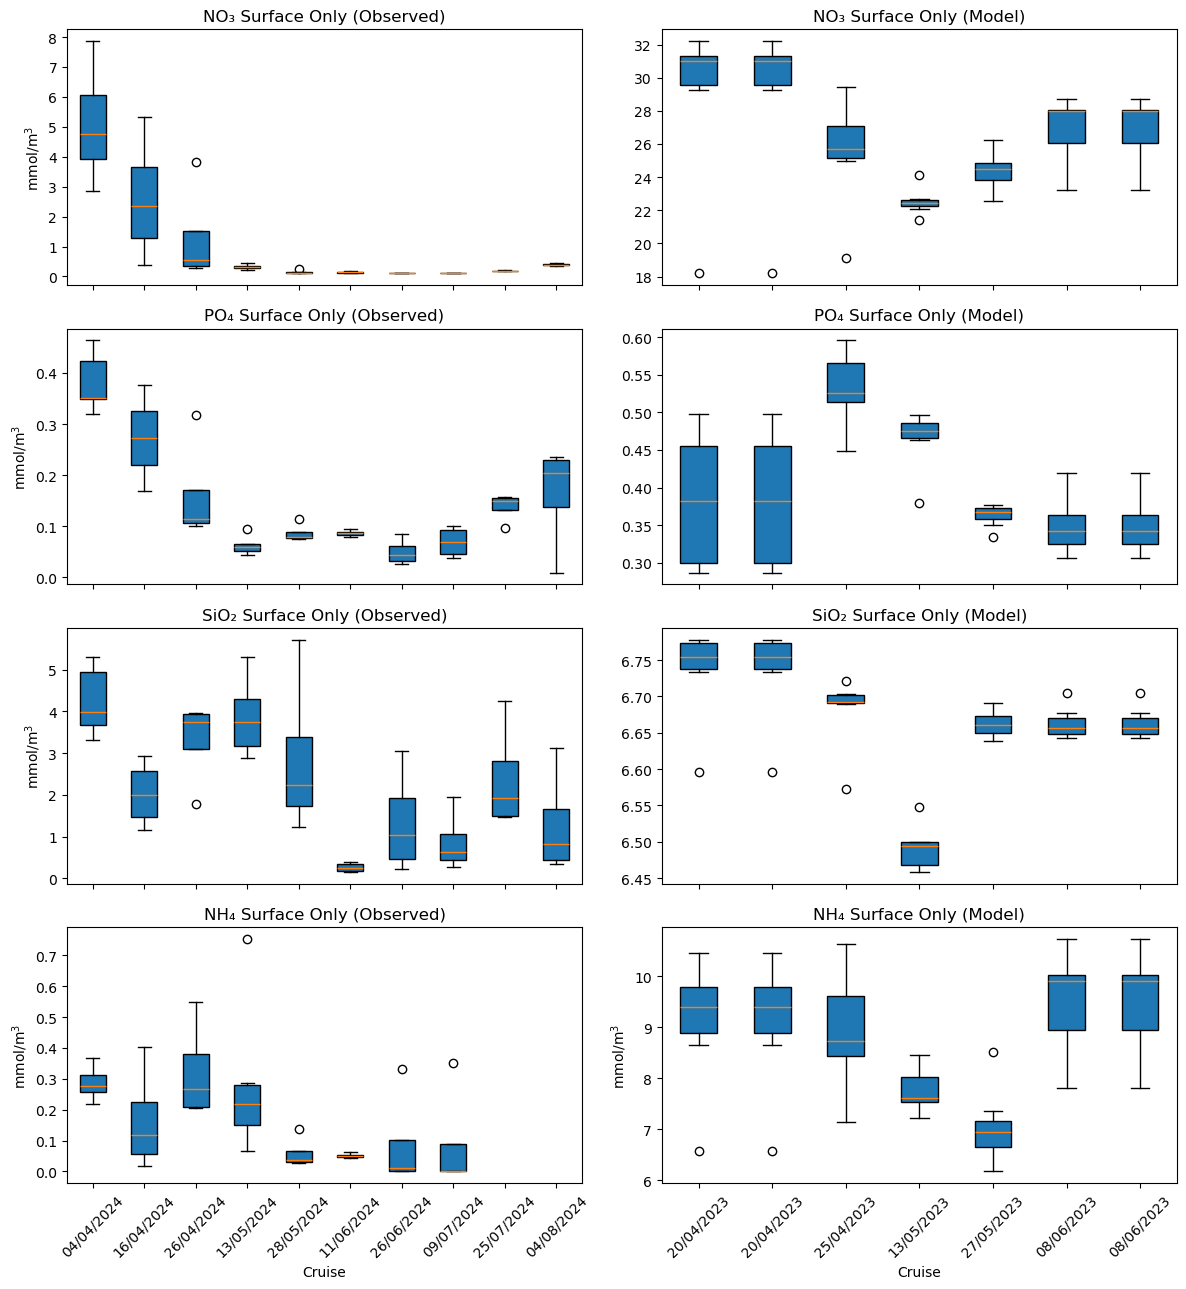

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create figure and subplots (4 rows for nutrients, 2 columns for observations vs. model)
fig = plt.figure(figsize=(12, 13))  # Wider figure for side-by-side comparison
gs = fig.add_gridspec(4, 2, height_ratios=[1, 1, 1, 1], width_ratios=[1, 1])  

# --- Data Extraction Functions ---
def extract_cruise_data(var, depth=0, num_cruises=10):
    """Extracts non-NaN values for a given variable across cruises (observations)."""
    cruises = []
    for i in range(num_cruises):
        data = np.hstack(var.isel(date=i) if depth is None else var.isel(date=i, depth_bin=depth))
        cruises.append(data[~np.isnan(data)])
    return cruises

def extract_model_data(var, depth=0, num_cruises=7):
    """Extracts non-NaN values from the model across time steps."""
    cruises = []
    for i in range(num_cruises):
        data = np.hstack(var.isel(time=i) if depth is None else var.isel(time=i, depth=depth))
        cruises.append(data[~np.isnan(data)])
    return cruises

# --- NO3 Boxplots ---
ax1_obs = fig.add_subplot(gs[0, 0])  # Observations
ax1_model = fig.add_subplot(gs[0, 1])  # Model

ax1_obs.boxplot(extract_cruise_data(obs['NO3']), patch_artist=True)
ax1_obs.set_title('NO₃ Surface Only (Observed)')
ax1_obs.set_ylabel('mmol/m$^3$')
ax1_obs.set_xticklabels([])

ax1_model.boxplot(extract_model_data(bgc_sub['NO3']), patch_artist=True)
ax1_model.set_title('NO₃ Surface Only (Model)')
ax1_model.set_xticklabels([])

# --- PO4 Boxplots ---
ax2_obs = fig.add_subplot(gs[1, 0])  # Observations
ax2_model = fig.add_subplot(gs[1, 1])  # Model

ax2_obs.boxplot(extract_cruise_data(obs['PO4']), patch_artist=True)
ax2_obs.set_title('PO₄ Surface Only (Observed)')
ax2_obs.set_ylabel('mmol/m$^3$')
ax2_obs.set_xticklabels([])

ax2_model.boxplot(extract_model_data(bgc_sub['PO4']), patch_artist=True)
ax2_model.set_title('PO₄ Surface Only (Model)')
ax2_model.set_xticklabels([])

# --- SiO2 Boxplots ---
ax3_obs = fig.add_subplot(gs[2, 0])  # Observations
ax3_model = fig.add_subplot(gs[2, 1])  # Model

ax3_obs.boxplot(extract_cruise_data(obs['SiO2']), patch_artist=True)
ax3_obs.set_title('SiO₂ Surface Only (Observed)')
ax3_obs.set_ylabel('mmol/m$^3$')
ax3_obs.set_xticklabels([])

ax3_model.boxplot(extract_model_data(bgc_sub['SiO3']), patch_artist=True)
ax3_model.set_title('SiO₂ Surface Only (Model)')
ax3_model.set_xticklabels([])

# --- NH4 Boxplots ---
ax4_obs = fig.add_subplot(gs[3, 0])  # Observations
ax4_model = fig.add_subplot(gs[3, 1])  # Model

ax4_obs.boxplot(extract_cruise_data(obs['NH4']), patch_artist=True)
ax4_obs.set_title('NH₄ Surface Only (Observed)')
ax4_obs.set_xlabel('Cruise')
ax4_obs.set_ylabel('mmol/m$^3$')
ax4_obs.set_xticklabels(pd.to_datetime(obs['date'].isel(date=slice(0,10))).strftime('%d/%m/%Y'), rotation=45)

ax4_model.boxplot(extract_model_data(bgc_sub['NH4']), patch_artist=True)
ax4_model.set_title('NH₄ Surface Only (Model)')
ax4_model.set_xlabel('Cruise')
ax4_model.set_ylabel('mmol/m$^3$')
ax4_model.set_xticklabels(pd.to_datetime(bgc_sub['time'].isel(time=slice(0,7))).strftime('%d/%m/%Y'), rotation=45)

plt.tight_layout()
plt.show()


/tmp/ipykernel_391752/1455962995.py:79: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ax4_model.set_xticklabels(pd.to_datetime(bgc_sub['time'].isel(time=slice(0,7))).strftime('%d/%m/%Y'), rotation=45)


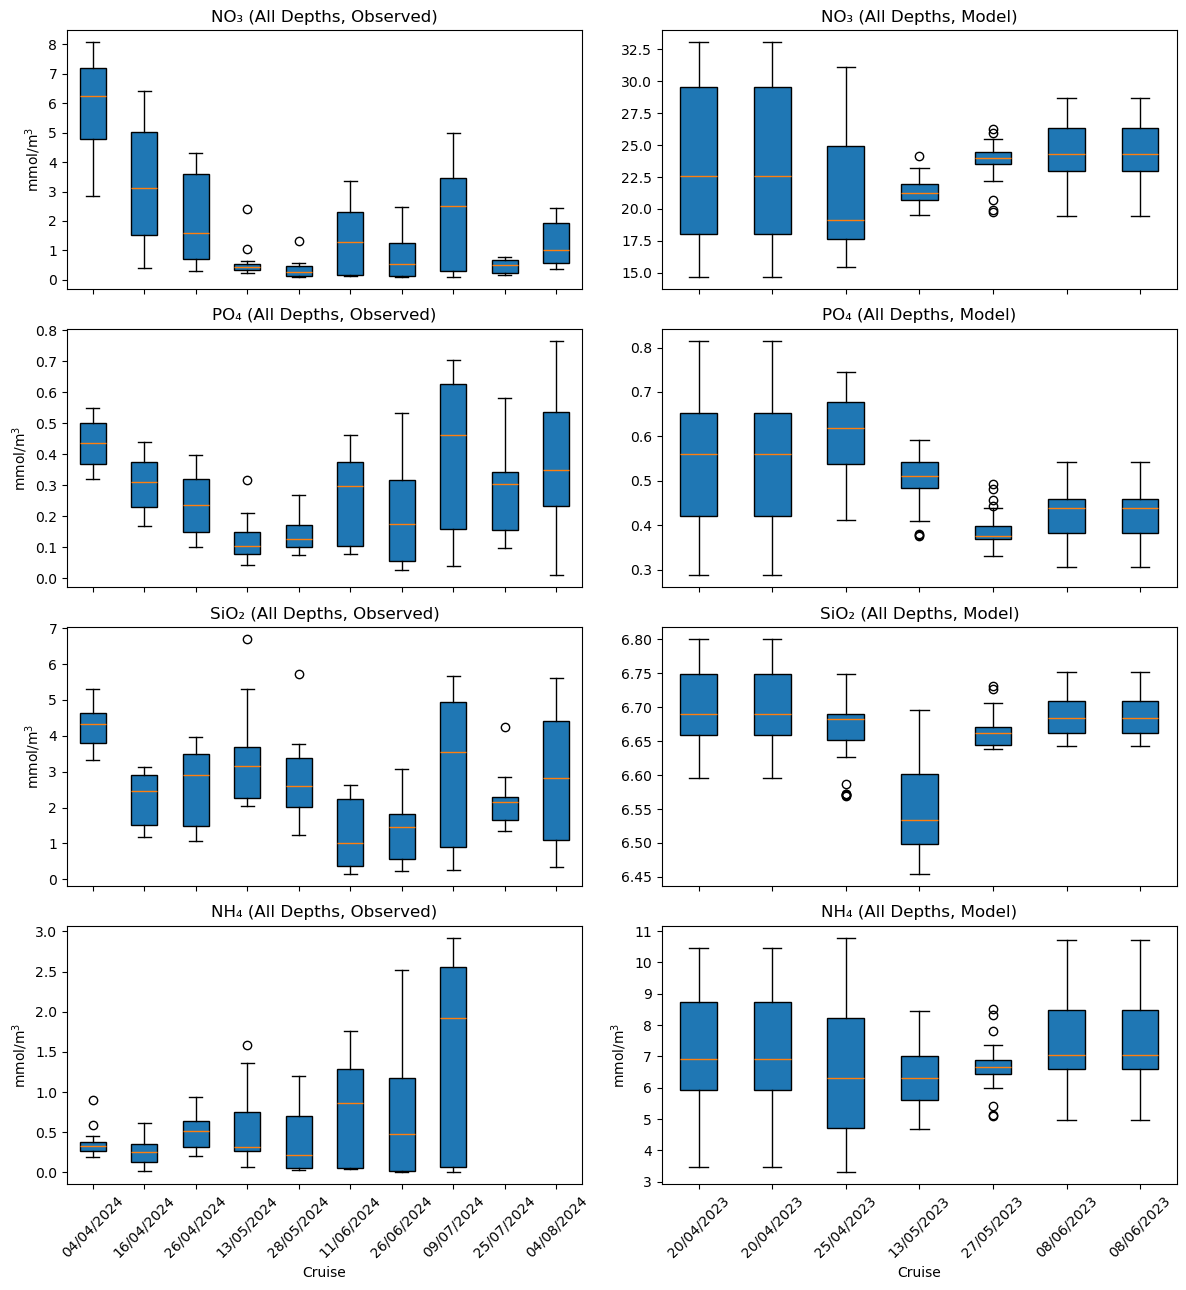

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create figure and subplots (4 rows for nutrients, 2 columns for observations vs. model)
fig = plt.figure(figsize=(12, 13))  # Wider figure for side-by-side comparison
gs = fig.add_gridspec(4, 2, height_ratios=[1, 1, 1, 1], width_ratios=[1, 1])  

# --- Data Extraction Functions ---
def extract_cruise_data(var, num_cruises=10):
    """Extracts non-NaN values for a given variable across all depths and cruises (observations)."""
    cruises = []
    for i in range(num_cruises):
        data = np.hstack(var.isel(date=i))  # Include all depth levels
        cruises.append(data[~np.isnan(data)])
    return cruises

def extract_model_data(var, num_cruises=7):
    """Extracts non-NaN values for a given variable across all depths and time steps (model)."""
    cruises = []
    for i in range(num_cruises):
        data = np.hstack(var.isel(time=i))  # Include all depth levels
        cruises.append(data[~np.isnan(data)])
    return cruises

# --- NO3 Boxplots (All Depths) ---
ax1_obs = fig.add_subplot(gs[0, 0])  # Observations
ax1_model = fig.add_subplot(gs[0, 1])  # Model

ax1_obs.boxplot(extract_cruise_data(obs['NO3']), patch_artist=True)
ax1_obs.set_title('NO₃ (All Depths, Observed)')
ax1_obs.set_ylabel('mmol/m$^3$')
ax1_obs.set_xticklabels([])

ax1_model.boxplot(extract_model_data(bgc_sub['NO3']), patch_artist=True)
ax1_model.set_title('NO₃ (All Depths, Model)')
ax1_model.set_xticklabels([])

# --- PO4 Boxplots (All Depths) ---
ax2_obs = fig.add_subplot(gs[1, 0])  # Observations
ax2_model = fig.add_subplot(gs[1, 1])  # Model

ax2_obs.boxplot(extract_cruise_data(obs['PO4']), patch_artist=True)
ax2_obs.set_title('PO₄ (All Depths, Observed)')
ax2_obs.set_ylabel('mmol/m$^3$')
ax2_obs.set_xticklabels([])

ax2_model.boxplot(extract_model_data(bgc_sub['PO4']), patch_artist=True)
ax2_model.set_title('PO₄ (All Depths, Model)')
ax2_model.set_xticklabels([])

# --- SiO2 Boxplots (All Depths) ---
ax3_obs = fig.add_subplot(gs[2, 0])  # Observations
ax3_model = fig.add_subplot(gs[2, 1])  # Model

ax3_obs.boxplot(extract_cruise_data(obs['SiO2']), patch_artist=True)
ax3_obs.set_title('SiO₂ (All Depths, Observed)')
ax3_obs.set_ylabel('mmol/m$^3$')
ax3_obs.set_xticklabels([])

ax3_model.boxplot(extract_model_data(bgc_sub['SiO3']), patch_artist=True)
ax3_model.set_title('SiO₂ (All Depths, Model)')
ax3_model.set_xticklabels([])

# --- NH4 Boxplots (All Depths) ---
ax4_obs = fig.add_subplot(gs[3, 0])  # Observations
ax4_model = fig.add_subplot(gs[3, 1])  # Model

ax4_obs.boxplot(extract_cruise_data(obs['NH4']), patch_artist=True)
ax4_obs.set_title('NH₄ (All Depths, Observed)')
ax4_obs.set_xlabel('Cruise')
ax4_obs.set_ylabel('mmol/m$^3$')
ax4_obs.set_xticklabels(pd.to_datetime(obs['date'].isel(date=slice(0,10))).strftime('%d/%m/%Y'), rotation=45)

ax4_model.boxplot(extract_model_data(bgc_sub['NH4']), patch_artist=True)
ax4_model.set_title('NH₄ (All Depths, Model)')
ax4_model.set_xlabel('Cruise')
ax4_model.set_ylabel('mmol/m$^3$')
ax4_model.set_xticklabels(pd.to_datetime(bgc_sub['time'].isel(time=slice(0,7))).strftime('%d/%m/%Y'), rotation=45)

plt.tight_layout()
plt.show()


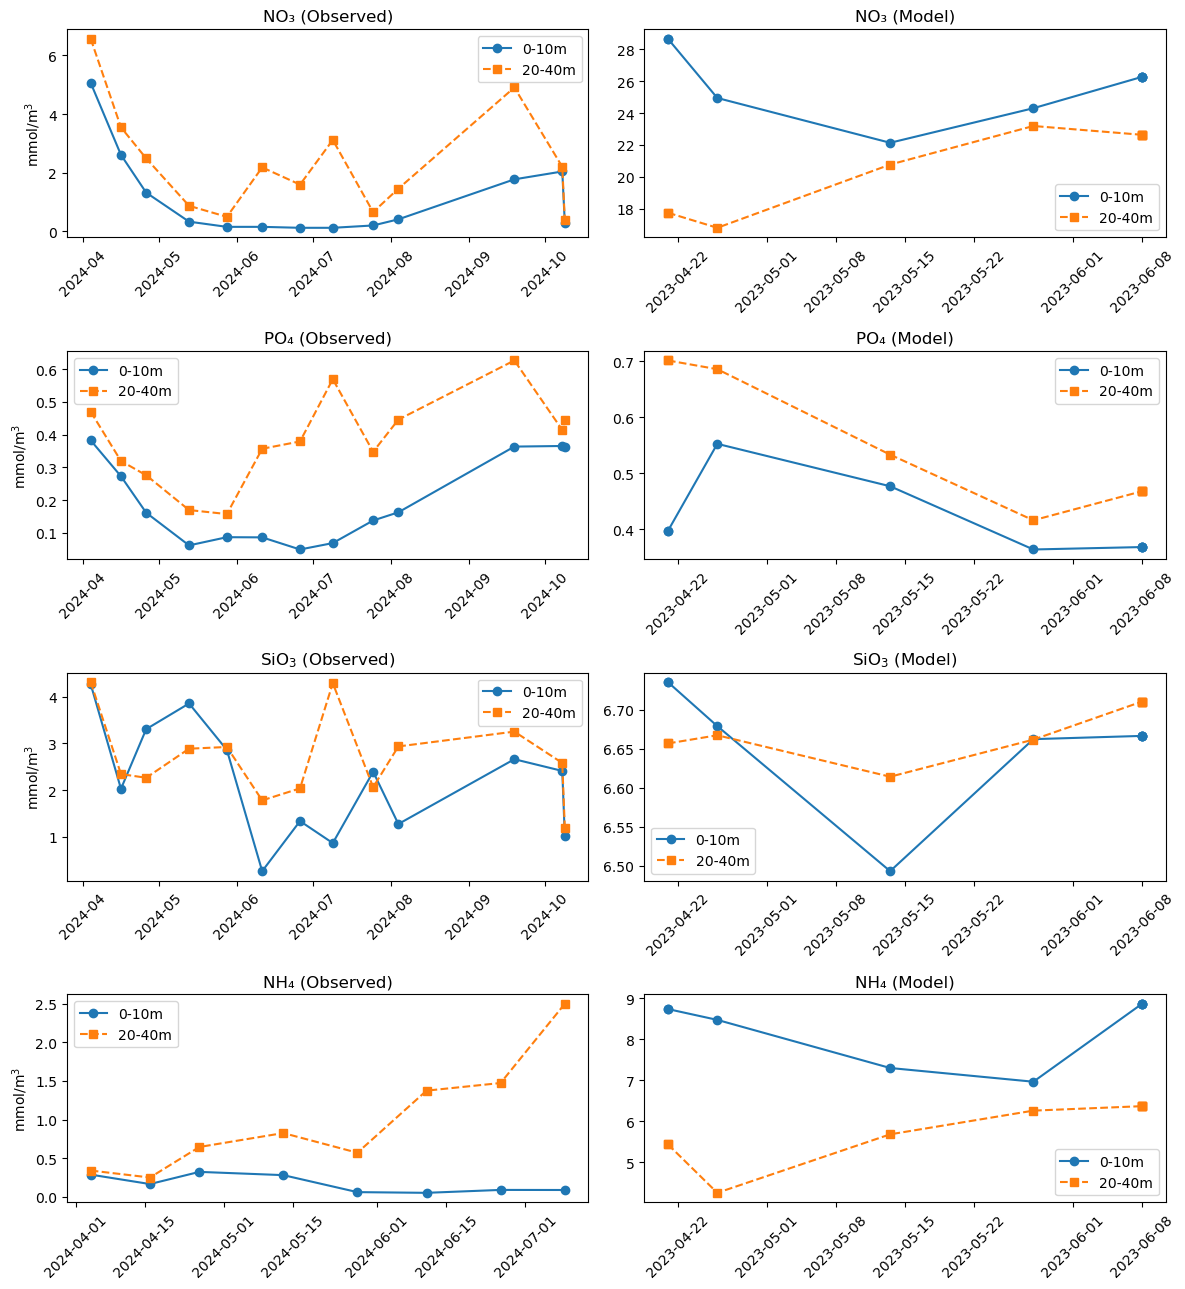

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create figure and subplots (4 rows for nutrients, 2 columns for observations vs. model)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 13), sharex=False)  

# --- Data Extraction Functions ---
def extract_depth_avg(var, depth_range, time_dim='date'):
    """Extracts mean value across a given depth range for each time step."""
    return var.sel(depth_bin=slice(*depth_range)).mean(dim='depth_bin', skipna=True)

def extract_depth_avg_model(var, depth_range, time_dim='time'):
    """Extracts mean value across a given depth range for each time step."""
    return var.sel(depth=slice(*depth_range)).mean(dim='depth', skipna=True)

# Define depth ranges
upper_depth_range = (0,5)   # Upper level (0-10 m)
lower_depth_range = (20, 40)  # Lower level (20-40 m)

# Define nutrients and their respective labels
nutrients = ['NO3', 'PO4', 'SiO2', 'NH4']
nutrients_m = ['NO3', 'PO4', 'SiO3', 'NH4']
titles = ['NO₃', 'PO₄', 'SiO$_3$', 'NH₄']

# --- Plot each nutrient ---
for i, nutrient in enumerate(nutrients):
    # Observations
    ax_obs = axes[i, 0]
    obs_upper = extract_depth_avg(obs[nutrient].mean('HV'), upper_depth_range)
    obs_lower = extract_depth_avg(obs[nutrient].mean('HV'), lower_depth_range)

    ax_obs.plot(obs['date'], obs_upper, label='0-10m', marker='o', linestyle='-')
    ax_obs.plot(obs['date'], obs_lower, label='20-40m', marker='s', linestyle='--')
    ax_obs.set_title(f'{titles[i]} (Observed)')
    ax_obs.set_ylabel('mmol/m$^3$')
    ax_obs.legend()
    ax_obs.tick_params(axis='x', rotation=45)  # Rotate x-axis labels


for i, nutrient in enumerate(nutrients_m):
    # Model
    ax_model = axes[i, 1]
    model_upper = extract_depth_avg_model(bgc_sub[nutrient].mean('location'), upper_depth_range, time_dim='time')
    model_lower = extract_depth_avg_model(bgc_sub[nutrient].mean('location'), lower_depth_range, time_dim='time')

    ax_model.plot(bgc_sub['time'], model_upper, label='0-10m', marker='o', linestyle='-')
    ax_model.plot(bgc_sub['time'], model_lower, label='20-40m', marker='s', linestyle='--')
    ax_model.set_title(f'{titles[i]} (Model)')
    ax_model.legend()
    ax_model.tick_params(axis='x', rotation=45)  # Rotate x-axis labels


plt.tight_layout()
plt.show()
